# MiniProject - Variant 3 - Group M

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

import sklearn
from sklearn.preprocessing import StandardScaler
import time
# import mat73 # requires pip install mat73

import pandas as pd
from align import align

from sklearn.decomposition import PCA, FastICA, NMF

from tqdm.notebook import tqdm
import gdown

## Loading data

<span style="color:orange">**Warning: this will slow down really hard your computer**</span>

In [2]:
!pip install gdown

In [3]:
import gdown

# url = "https://drive.google.com/uc?id=1fhX5gCvmqkFrQ_Um9WXzYdmDUCXadzrJ"
# output = "sub/s1.mat"
# gdown.download(url, output, quiet = False)

# url = "https://drive.google.com/uc?id=1fhc-JCSnzE_oDOMszP9FsgmpxFUFAwYP"
# output = "sub/s2.mat"
# gdown.download(url, output, quiet = False)

# url = "https://drive.google.com/uc?id=1yWCwEKDaa97ZD44t1tS8i1IOJ5GIbROp"
# output = "sub/s3.mat"
# gdown.download(url, output, quiet = False)

In [4]:
n_subject = 3   

sub_files = []
for i in range(1, n_subject+1):
    sub_files.append(loadmat('sub/s' + str(i) + '.mat'))
    print("The type of the file nb " + str(i) + " is: " + str(type(sub_files[i-1])))
    print("The keys of the file nb " + str(i) + " are: " + str(sub_files[i-1].keys()))
    print("\n\n")

The type of the file nb 1 is: <class 'dict'>
The keys of the file nb 1 are: dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])



The type of the file nb 2 is: <class 'dict'>
The keys of the file nb 2 are: dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])



The type of the file nb 3 is: <class 'dict'>
The keys of the file nb 3 are: dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])





Note for us: They say the signals were captured on 128 channels. From my understanding, its 64 channels on EMG_extensors, and 64 channels on EMG_flexors 

In [4]:
print("number of uniques: " + str(len(np.unique(sub_files[0]["adjusted_class_new"]))))
print("number of uniques: " + str(len(np.unique(sub_files[0]["adjusted_repetition_new"]))))
print("number of uniques: " + str(sub_files[0]['emg_flexors_new'].shape))

number of uniques: 31
number of uniques: 6
number of uniques: (3000000, 8, 8)


## Part 1

### Preprocessing the data


In [5]:
# print(f'What are the shape of the data that we are working with? EMG_extensors: {emg_extensors.shape}, EMG_flexors {emg_flexors.shape}, adjusted_epetition {adjusted_repetition.shape}')

The movement should be the stimuli. We know there are 65 movements + 1 for the resting state, and the only keys to have 66 unique elements are `adjusted_class` and `class`, which correspondonds to the data description in https://www.nature.com/articles/s41597-021-00843-9

<span style="color:orange">check if adjusted_XXX are preprocessed for better correspondance to real movement or not</span>

<span style="color:orange">**WARNING: This will also slow down your computer**</span>

<span style="color:orange">**WARNING: I may be using incorrectly the number of channels**</span>

<span style="color:orange">**WARNING: Maybe we need to remove the outliers, thanks to the corresponding key**</span>

<span style="color:red">**ERROR: Laptop on fire 🔥**</span>


In [10]:
def preprocess_data(sub, sub_files, last_value=1000000, peak_value=2):
    #Fs = sub_files[sub]['Fs'][0,0].copy()
    # adjusted_class = sub_files[sub]['adjusted_class_new'].copy()
    # adjusted_repetition = sub_files[sub]['adjusted_repetition_new'].copy()
    emg = sub_files[sub]['emg_flexors_new'].copy()
       
    emg[emg > peak_value] = peak_value
    emg[emg < -peak_value] = -peak_value
    # n_repetitions = len(np.unique(adjusted_repetition)) - 1 # -1 because 0 is not a repetition
    # n_stimuli = len(np.unique(adjusted_class)) - 1 # -1 because 0 is not a repetition
    n_channels = emg.shape[1]*emg.shape[2]

    emg = emg.reshape(emg.shape[0], n_channels)
    
    # print(f'How many types of movement are there? {n_stimuli}') 
    # print(f'How many repetitions are there? {n_repetitions}') 
    
    #sos = butter(N=N, fs=Fs, Wn=Wn, btype="bandpass", output="sos")
    #emg_filtered = sosfiltfilt(sos, emg.T).T
    
    # Easier method to compute the envelope 

    emg_subsampled = emg[::2, :] # subsample by steps of 2 to reduce data size for easier computation
    emg_rectified = emg_subsampled ** 2 # rectify the signal. We could also use abs

    weights = np.ones(200) / 200        
    emg_envelope_200 = convolve1d(emg_rectified, weights=weights, axis=0)
    
    emg_envelope_200 = emg_envelope_200[:last_value]
    return emg_envelope_200 #, emg_filtered

In [13]:
#emg_flexors_envelope_200, emg_filtered = preprocess_data(sub=0, sub_files=sub_files)
# emg_flexors_envelope_200, adjusted_class, adjusted_repetition = preprocess_data(sub=0, sub_files=sub_files)

emg_flexors_envelope_200 = preprocess_data(sub=0, sub_files=sub_files)

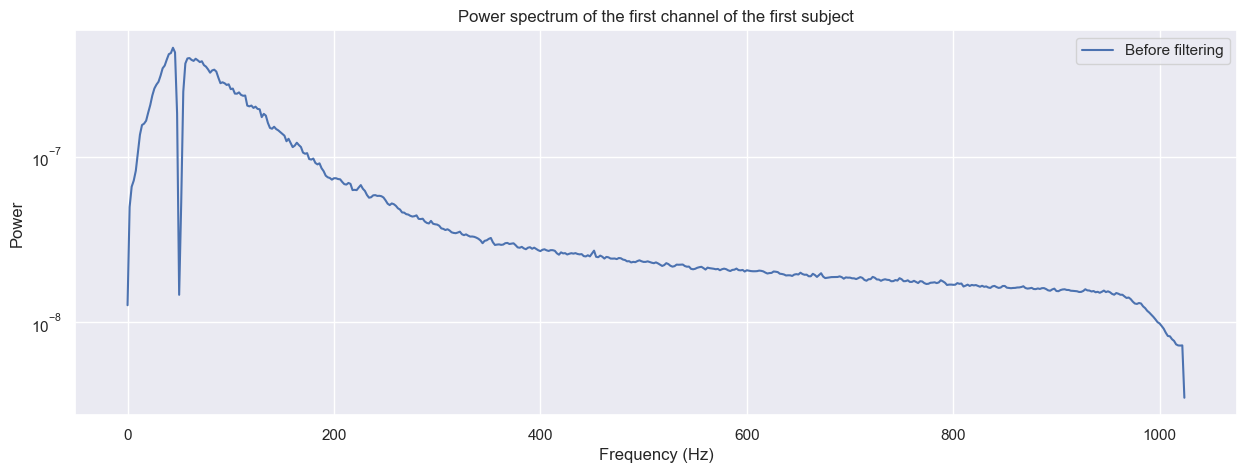

In [14]:
# Get spectra power sub_files[0]["emg_flexors_new"][:,0,0]

freq_pre, power_pre = welch(sub_files[0]["emg_flexors_new"][:,0,0], fs=sub_files[0]['Fs'][0,0], nperseg=1024)
# freq_after, power_after = welch(emg_filtered[:,0], fs=sub_files[0]['Fs'][0,0], nperseg=1024)

# Plot them

plt.figure(figsize=(15,5))

plt.semilogy(freq_pre, power_pre, label="Before filtering")
# plt.semilogy(freq_after, power_after, label="After filtering")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.title("Power spectrum of the first channel of the first subject")

plt.show()


### Visualizing the data

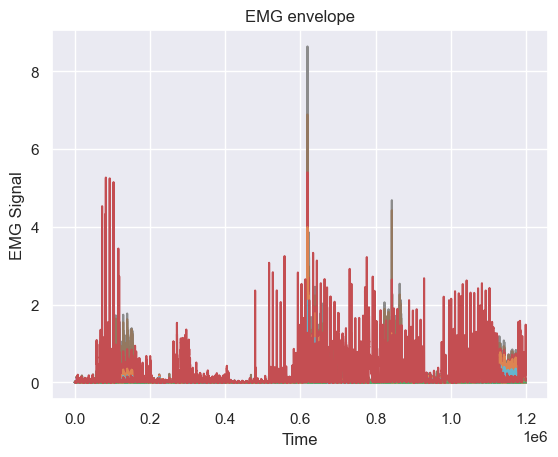

In [76]:
emg_flexors_envelope_200 = emg_flexors_envelope_200[:1200000]
plt.plot(emg_flexors_envelope_200, label="EMG envelope")
plt.title('EMG envelope')
plt.xlabel('Time')
plt.ylabel('EMG Signal')
plt.show()

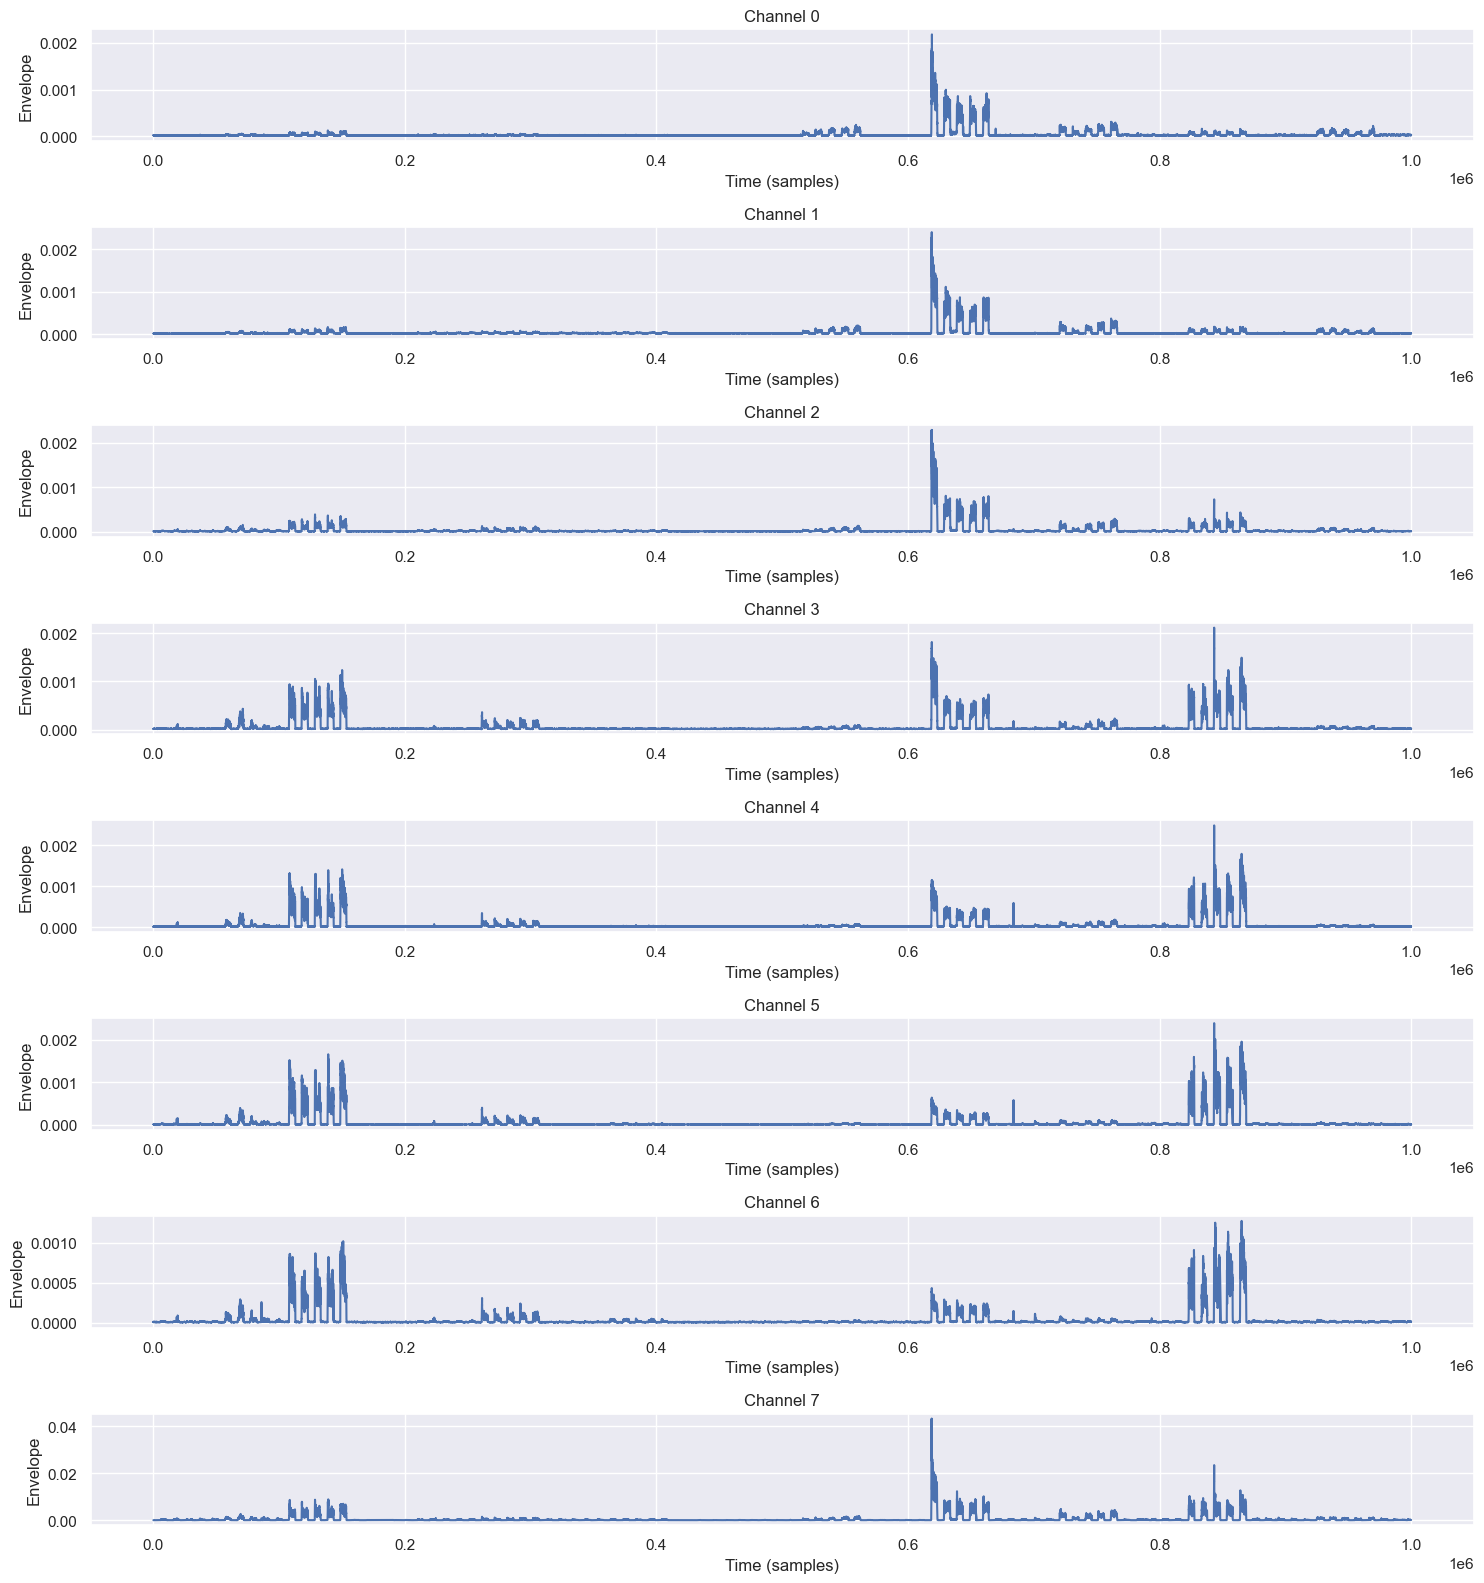

In [15]:
# #lets take a quick look at the data

fig, ax = plt.subplots(8, 1, figsize=(15, 16))
for i in range(8):
    ax[i].plot(emg_flexors_envelope_200[:, i])
    ax[i].set_title("Channel {}".format(i))
    ax[i].set_xlabel("Time (samples)")
    ax[i].set_ylabel("Envelope")

plt.tight_layout()

## Part 2

*Compute the spatial synergies using different blind source separation algorithms
(e.g. PCA, ICA, NMF). Are the synergies stable?*

### Spatial synergies using BSS

### NMF

In [26]:
r_2_nmf = np.zeros(6)
for syn in [1,2,3,4,5,6]:
    nmf = NMF(n_components=syn, init="nndsvda", max_iter=1000)
    nmf.fit(emg_flexors_envelope_200)
    # Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
    W_nmf = nmf.transform(emg_flexors_envelope_200)
    H_nmf = nmf.components_
    channel_envelope_pred = np.dot(W_nmf, H_nmf)
    r_2_nmf[syn-1] = sklearn.metrics.r2_score(emg_flexors_envelope_200, channel_envelope_pred)
    print("r2 score for " + str(syn) + " synergies is: " + str(r_2_nmf[syn-1]))

c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


r2 score for 1 synergies is: -0.006161366410881053
r2 score for 2 synergies is: 0.13580784655435146
r2 score for 3 synergies is: 0.3147803103865954
r2 score for 4 synergies is: 0.4390121505248846
r2 score for 5 synergies is: 0.5067211539440384


c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


r2 score for 6 synergies is: 0.5283382615017528


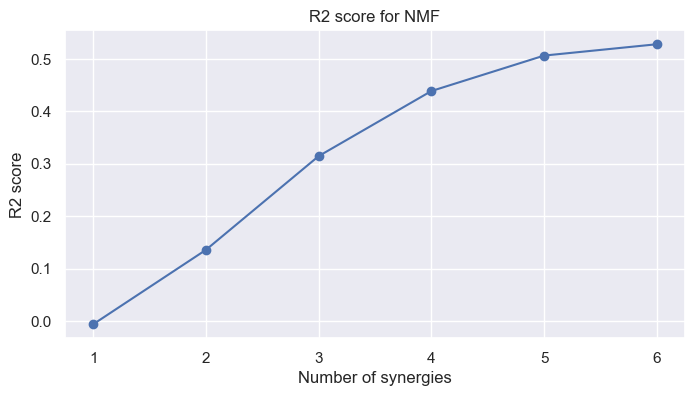

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(r_2_nmf, 'o-')
plt.title('R2 score for NMF')
plt.xlabel('Number of synergies')
plt.ylabel('R2 score')
plt.xticks(np.arange(6), np.arange(1,7))
plt.show()

In [35]:
# For now let's just use 5 components. Parameters: init="nndsvda", max_iter=500.
nmf = NMF(n_components=5, init="nndsvda", max_iter=500)

t = time.time()
nmf.fit(emg_flexors_envelope_200)
print("Elapsed time: ", time.time() - t)

# Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W_nmf = nmf.transform(emg_flexors_envelope_200)
H_nmf = nmf.components_

Elapsed time:  43.1808397769928


In [13]:
def plot_synergies(envelope, H, W, title=None):
    
    # Plot synthetic EMG data
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(envelope)
    plt.title('EMG envelope')
    plt.xlabel('Time')
    plt.ylabel('EMG Signal')

    # Plot extracted synergies
    plt.subplot(3, 1, 2)
    plt.plot(H.T)
    plt.title('Extracted Muscle Synergies')
    plt.xlabel('Channels')
    plt.ylabel('Synergy Value')

    # Plot extracted activation coefficients
    plt.subplot(3, 1, 3)
    plt.plot(W)
    plt.title('Extracted Activation Coefficients')
    plt.xlabel('Time')
    plt.ylabel('Activation Level')
    
    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()

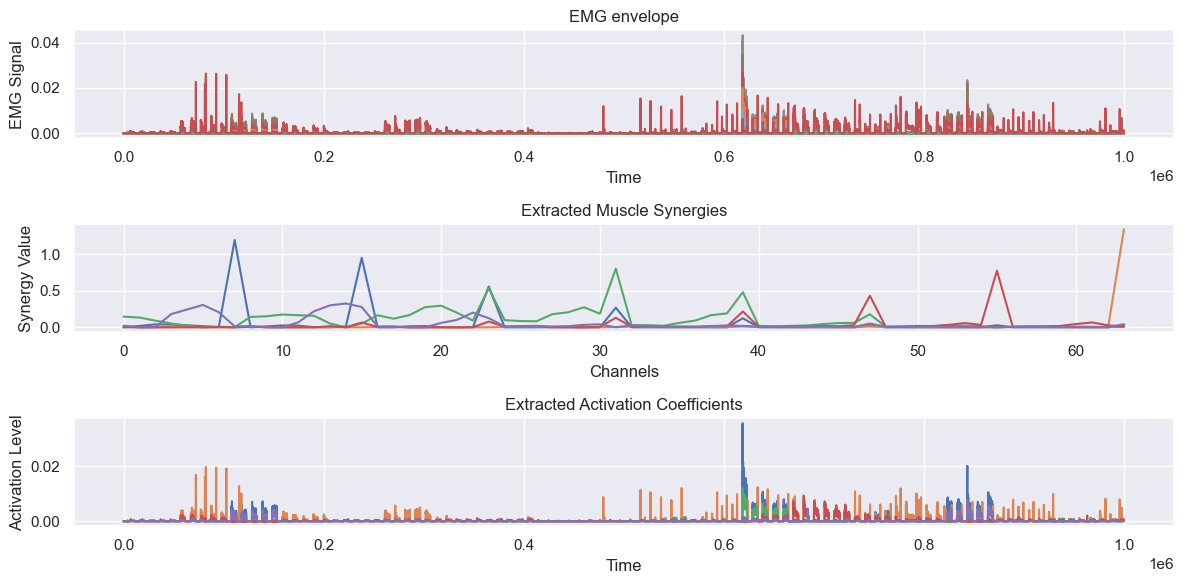

In [37]:
plot_synergies(emg_flexors_envelope_200, H_nmf, W_nmf)

### PCA

In [57]:
means_channel = np.mean(emg_flexors_envelope_200, axis=0)
centered_emg = emg_flexors_envelope_200 - np.ones(emg_flexors_envelope_200.shape) * means_channel

print("Mean of means of channels: ", np.mean(np.mean(emg_flexors_envelope_200, axis=0)))

Mean of means of channels:  8.28237891937753e-05


In [58]:
r_2_pca = np.zeros(6)
for syn in [1,2,3,4,5,6]:
    pca = PCA(n_components=syn)
    # Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
    W_pca = pca.fit_transform(centered_emg)
    H_pca = pca.components_
    channel_envelope_pred = np.dot(W_pca, H_pca)
    r_2_pca[syn-1] = sklearn.metrics.r2_score(centered_emg, channel_envelope_pred)
    print("r2 score for " + str(syn) + " synergies is: " + str(r_2_pca[syn-1]))

r2 score for 1 synergies is: 0.540509017097425
r2 score for 2 synergies is: 0.5935130429282334
r2 score for 3 synergies is: 0.7711836713519149
r2 score for 4 synergies is: 0.8535404646066079
r2 score for 5 synergies is: 0.878096454292457
r2 score for 6 synergies is: 0.8853757144023573


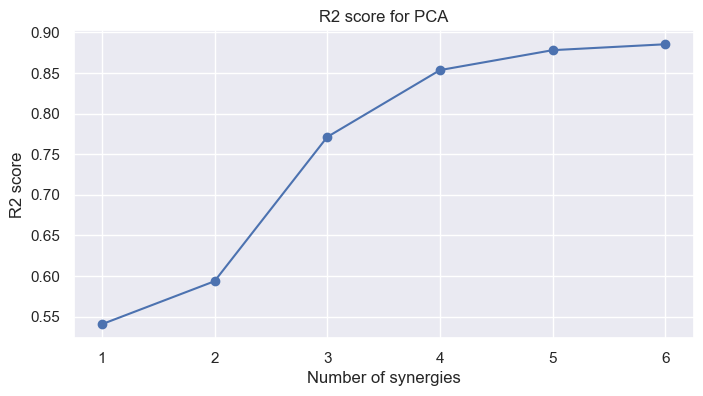

In [59]:
plt.figure(figsize=(8, 4))
plt.plot(r_2_pca, 'o-')
plt.title('R2 score for PCA')
plt.xlabel('Number of synergies')
plt.ylabel('R2 score')
plt.xticks(np.arange(6), np.arange(1,7))
plt.show()

In [78]:
pca = PCA(n_components=5)

W_pca = pca.fit_transform(centered_emg)
H_pca = pca.components_

# Plot synthetic EMG data

plot_synergies(emg_flexors_envelope_200, H_pca, W_pca)  

### ICA

In [51]:
r_2_ica = np.zeros(6)
for syn in [1,2,3,4,5,6]:
    ica = FastICA(n_components=syn)
    ica.fit(centered_emg)
    # Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
    W_ica = ica.transform(centered_emg)
    H_ica = ica.mixing_.T
    channel_envelope_pred_ica = W_ica @ H_ica
    r_2_ica[syn-1] = sklearn.metrics.r2_score(centered_emg, channel_envelope_pred_ica)
    print("r2 score for " + str(syn) + " synergies is: " + str(r_2_ica[syn-1]))

r2 score for 1 synergies is: 0.5405090170974256
r2 score for 2 synergies is: 0.5935130429282335
r2 score for 3 synergies is: 0.7711836713519149
r2 score for 4 synergies is: 0.853540464606608
r2 score for 5 synergies is: 0.8780964542924634
r2 score for 6 synergies is: 0.8853757144025529


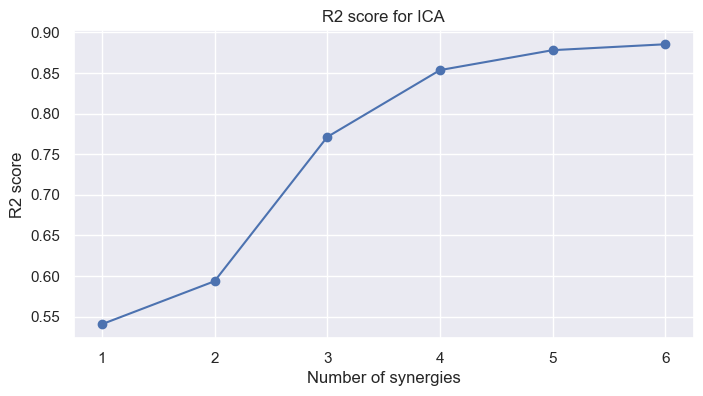

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(r_2_ica, 'o-')
plt.title('R2 score for ICA')
plt.xlabel('Number of synergies')
plt.ylabel('R2 score')
plt.xticks(np.arange(6), np.arange(1,7))
plt.show()

In [94]:
ica = FastICA(n_components=5)
# Use ica.transform (W) and ica.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W_ica = ica.fit_transform(centered_emg)
H_ica = ica.mixing_.T

Text(0.5, 1.0, 'First channel')

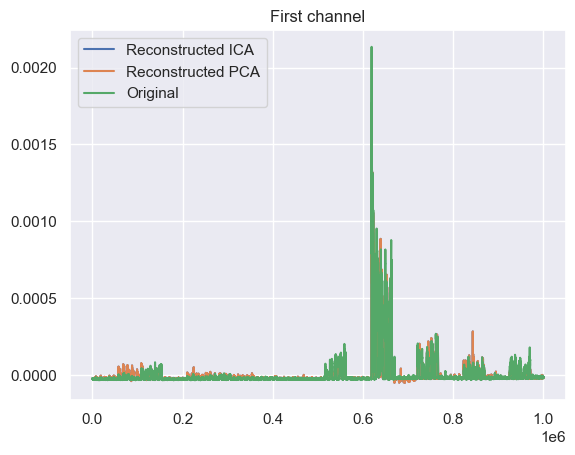

In [98]:
reconstructed_pca = W_pca @ H_pca
reconstructed_ica = W_ica @ H_ica

plt.plot(reconstructed_ica[:, 0], label="Reconstructed ICA")
plt.plot(reconstructed_pca[:, 0], label="Reconstructed PCA")
plt.plot(centered_emg[:, 0], label="Original")
plt.legend()
plt.title("First channel")

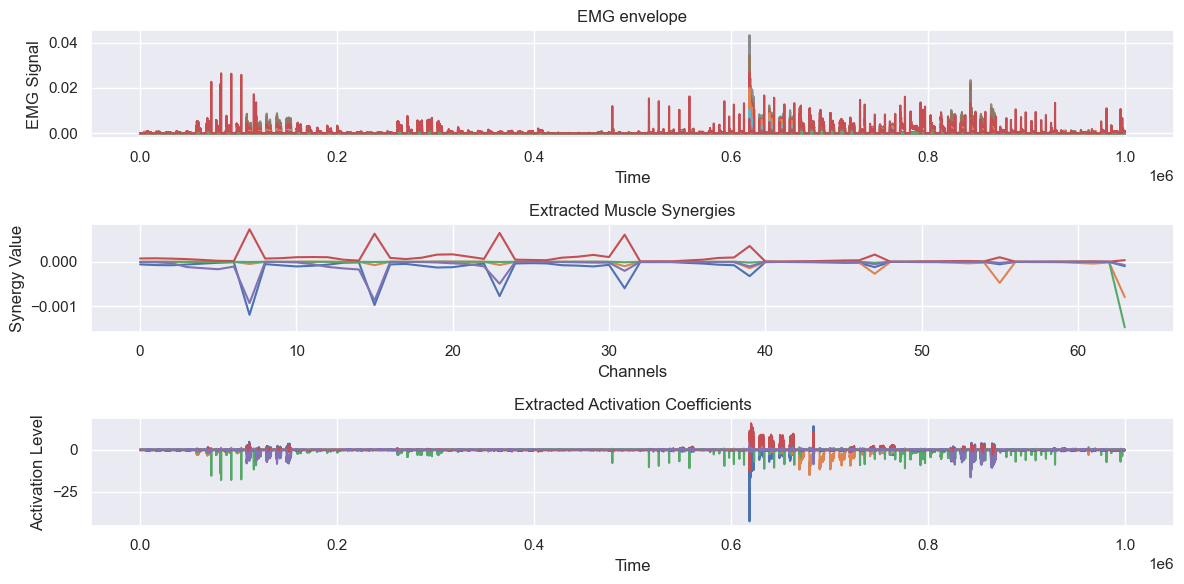

In [82]:
# Plot synthetic EMG data
plot_synergies(emg_flexors_envelope_200, H_ica, W_ica)

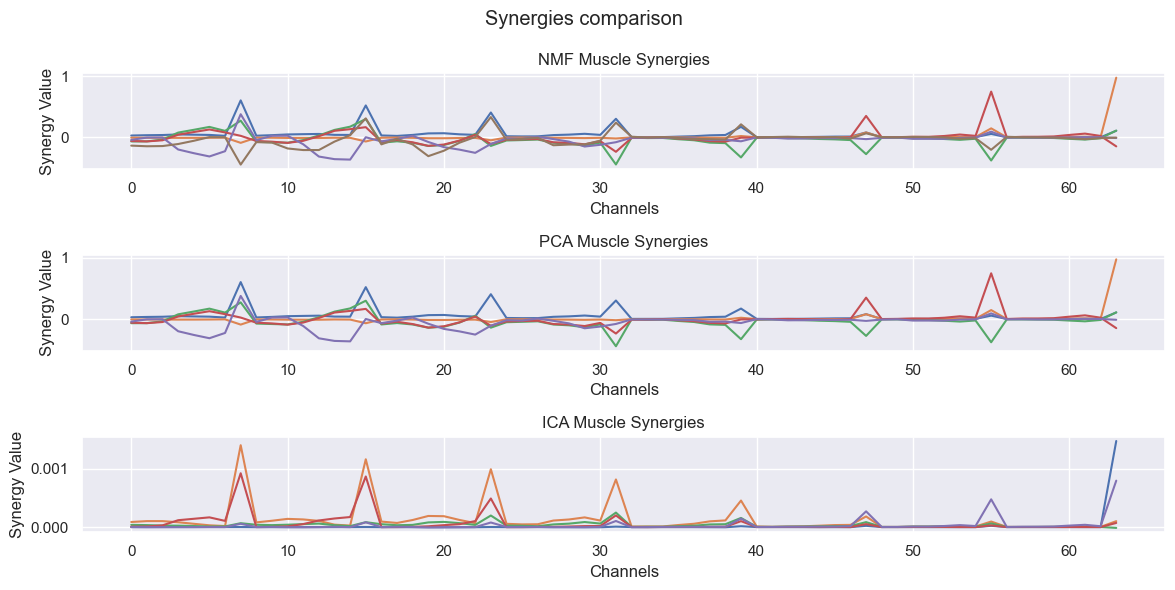

In [66]:
# Plot synthetic EMG data
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(H_nmf.T)
plt.title('NMF Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

# Plot extracted synergies
plt.subplot(3, 1, 2)
plt.plot(H_pca.T)
plt.title('PCA Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

# Plot extracted activation coefficients
plt.subplot(3, 1, 3)
plt.plot(H_ica.T)
plt.title('ICA Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.suptitle("Synergies comparison")
plt.tight_layout()
plt.show()

## Part 3

*Compute the spatial synergies corresponding to different subsets of the data
samples. Are the synergies stable across the different subsets?*

### Comparaison



In [69]:
n_subsets: int = 10
BSS = "NMF"

if BSS == "NMF":
    model = NMF(n_components=5, init="nndsvda", max_iter=500)
elif BSS == "PCA":
    model = PCA(n_components=5) 
elif BSS == "ICA":
    model = FastICA(n_components=5)
    
W_sub: list = []
H_sub: list = []
interval: int = int(emg_flexors_envelope_200.shape[0]/n_subsets)

for i in range(n_subsets):
    model.fit(emg_flexors_envelope_200[i*interval:(i+1)*interval])
    
    W_sub.append(model.transform(emg_flexors_envelope_200[i*interval:(i+1)*interval]))
    H_sub.append(model.components_)

c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.w

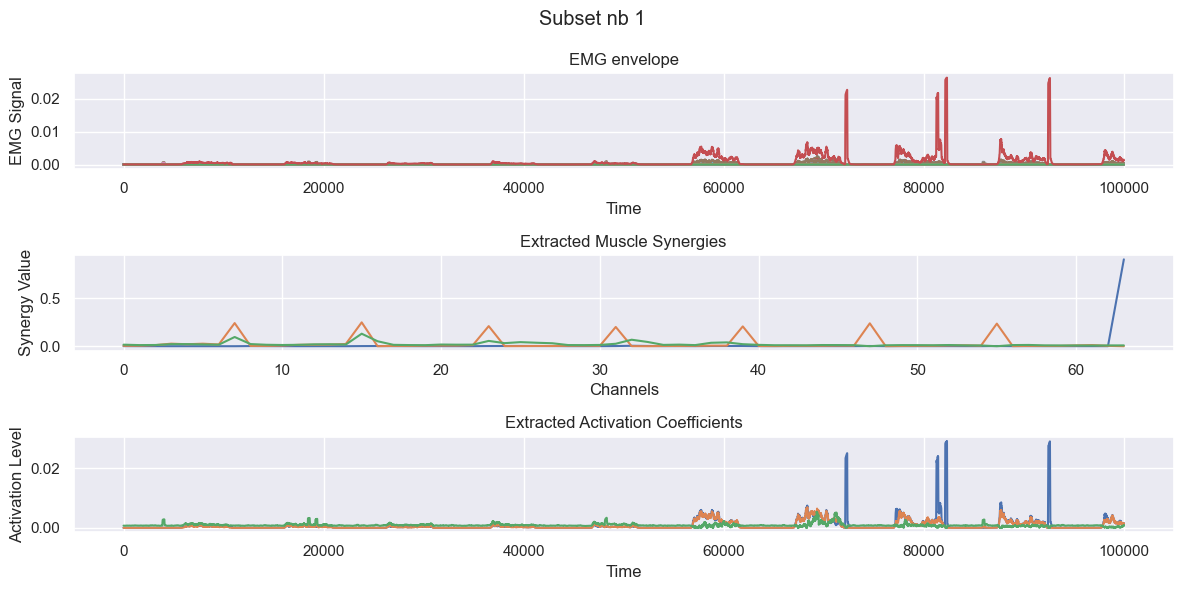

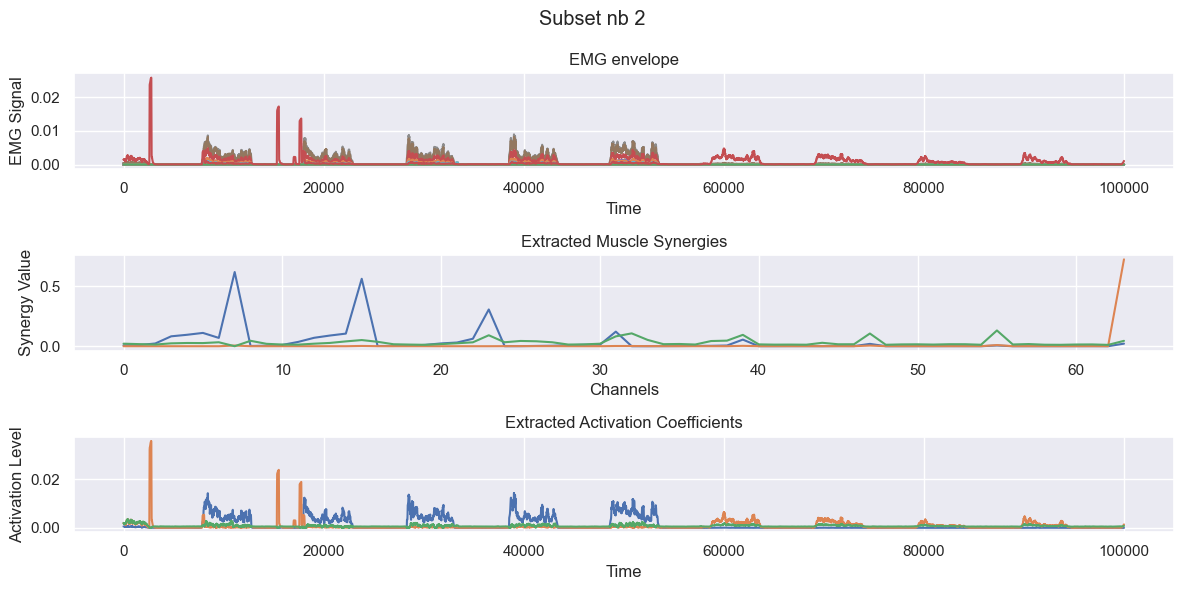

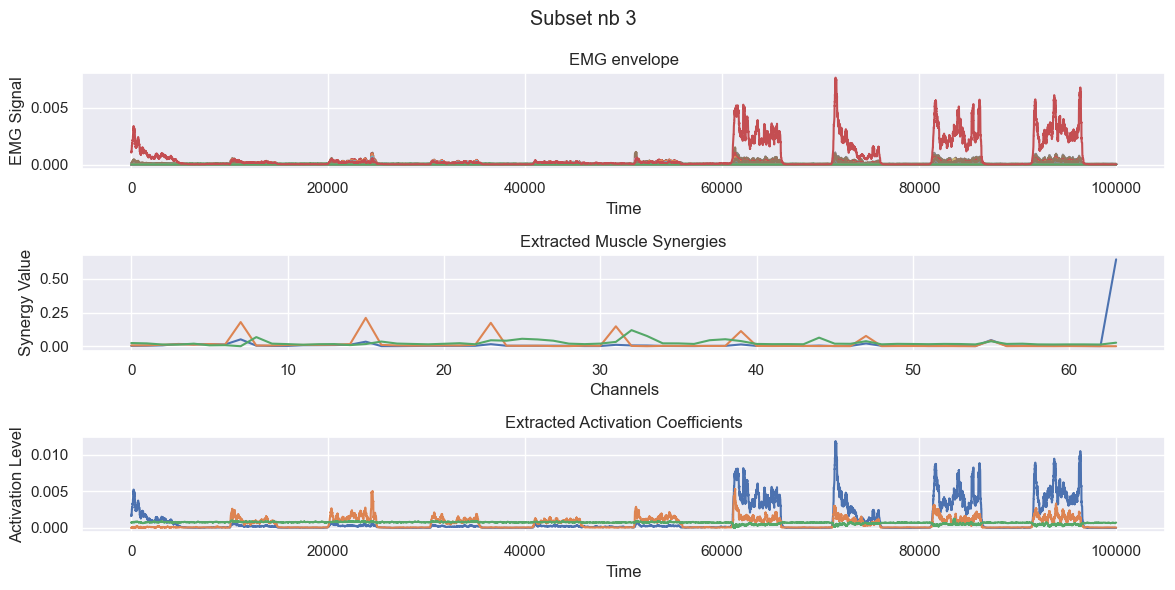

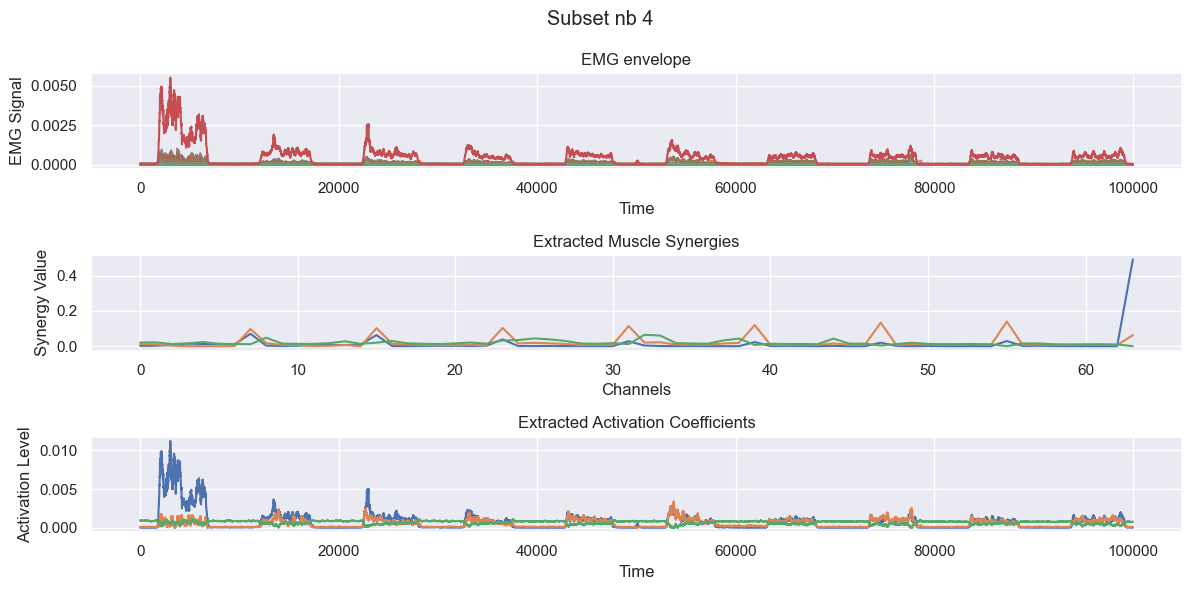

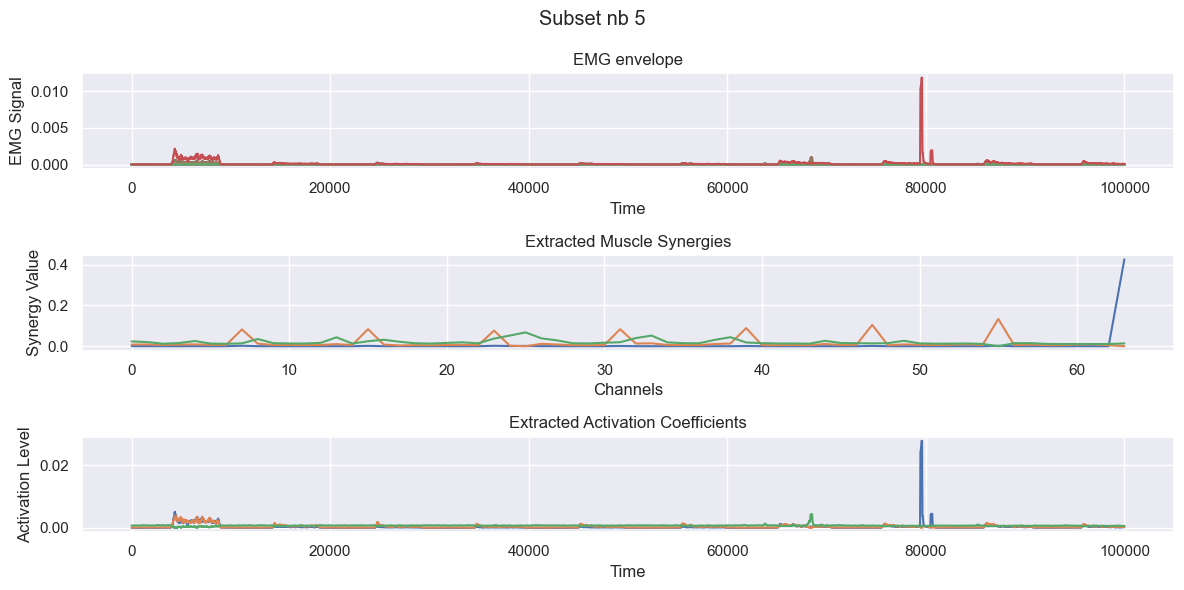

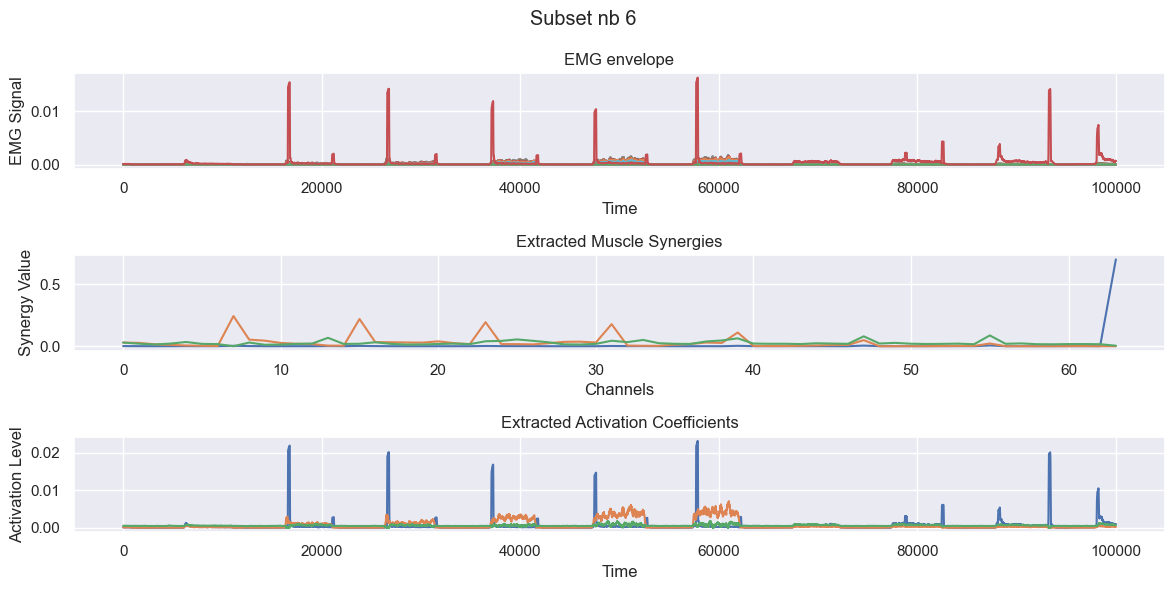

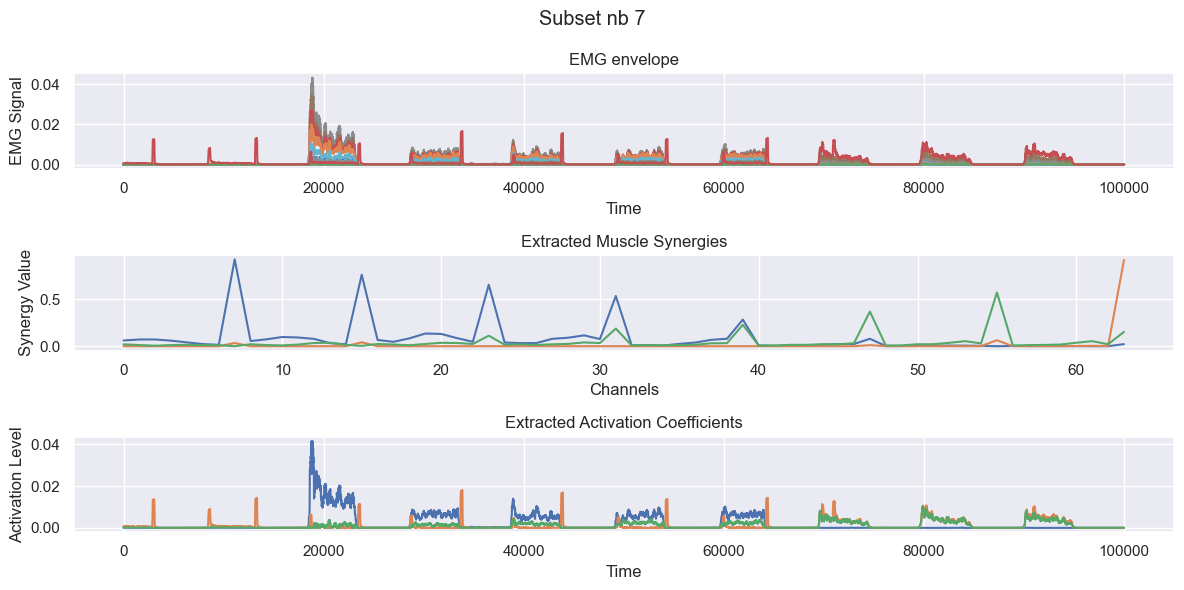

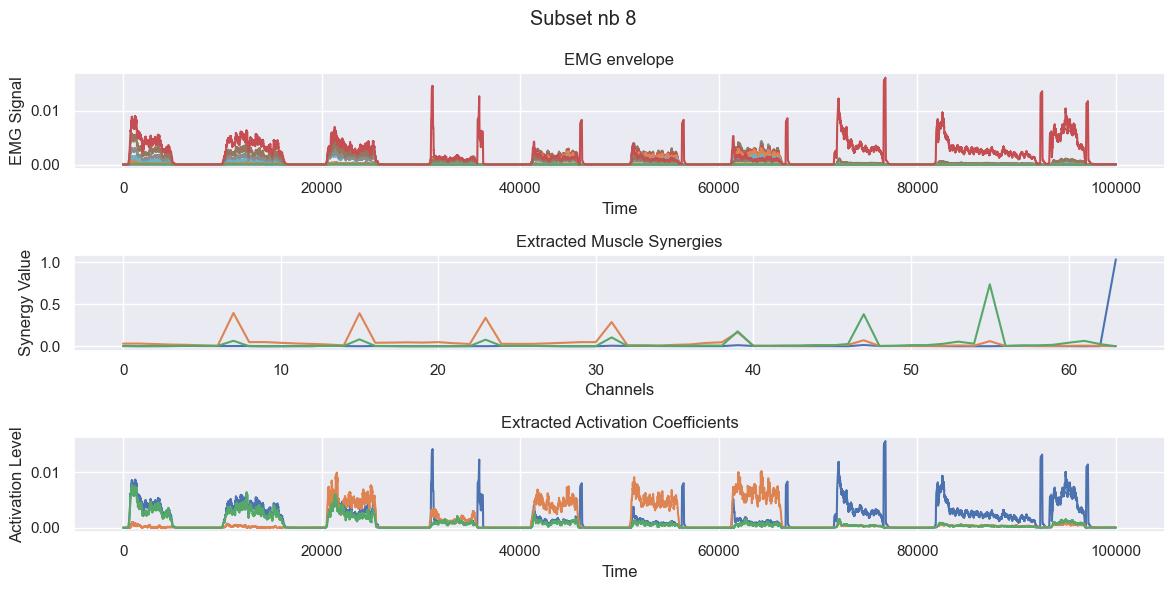

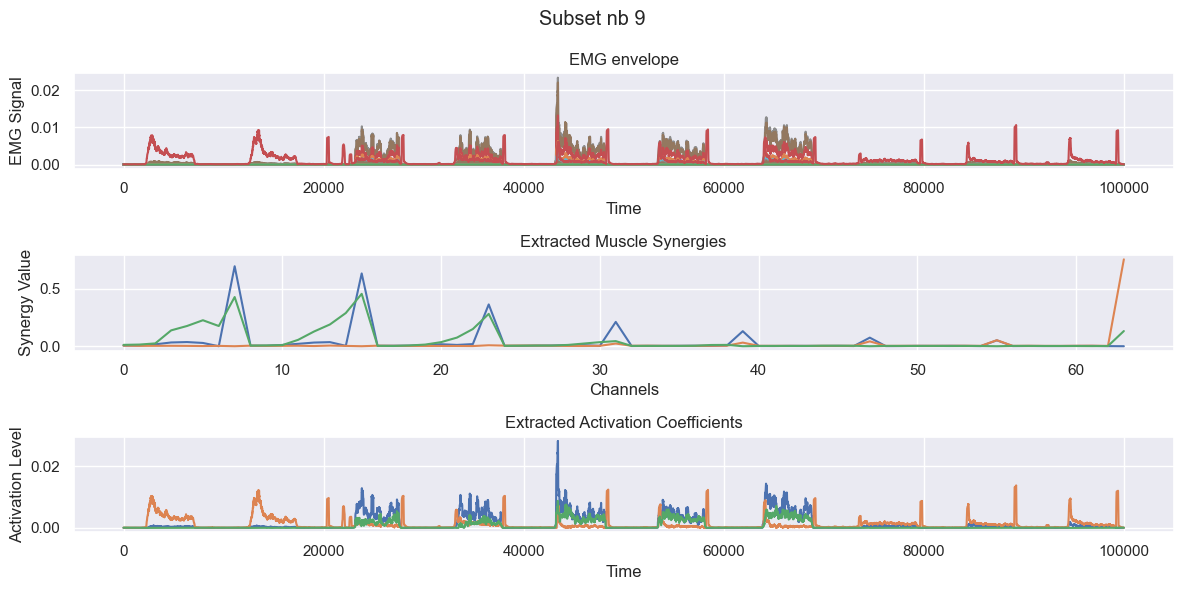

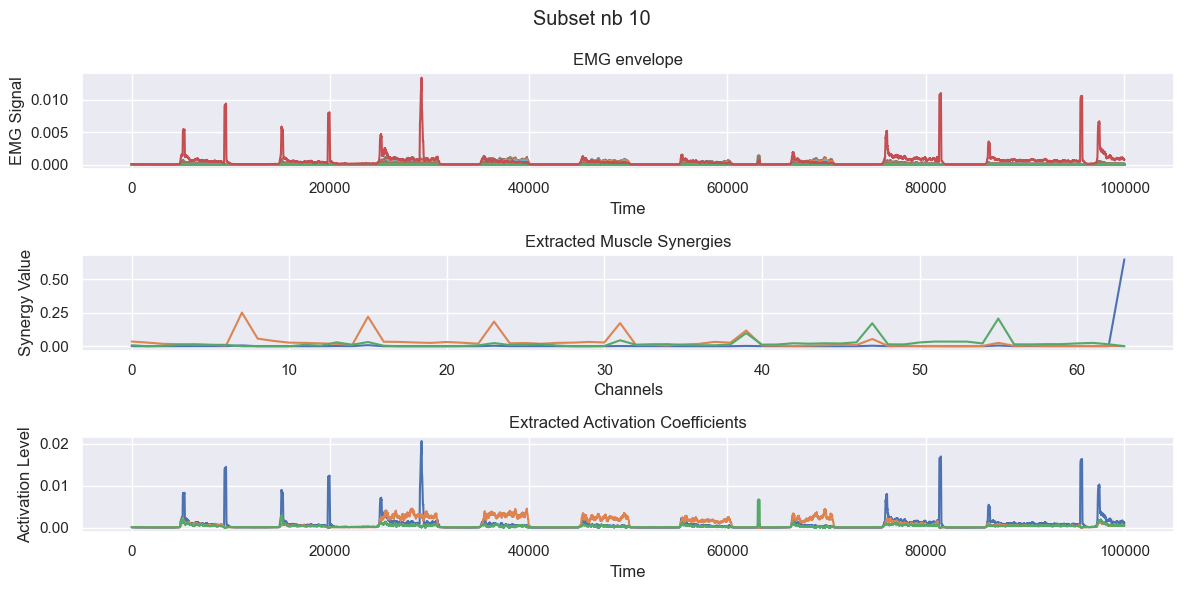

In [68]:
for i in range(n_subsets):
    plot_synergies(emg_flexors_envelope_200[i*interval:(i+1)*interval], H_sub[i], W_sub[i], "Subset nb {}".format(i+1))

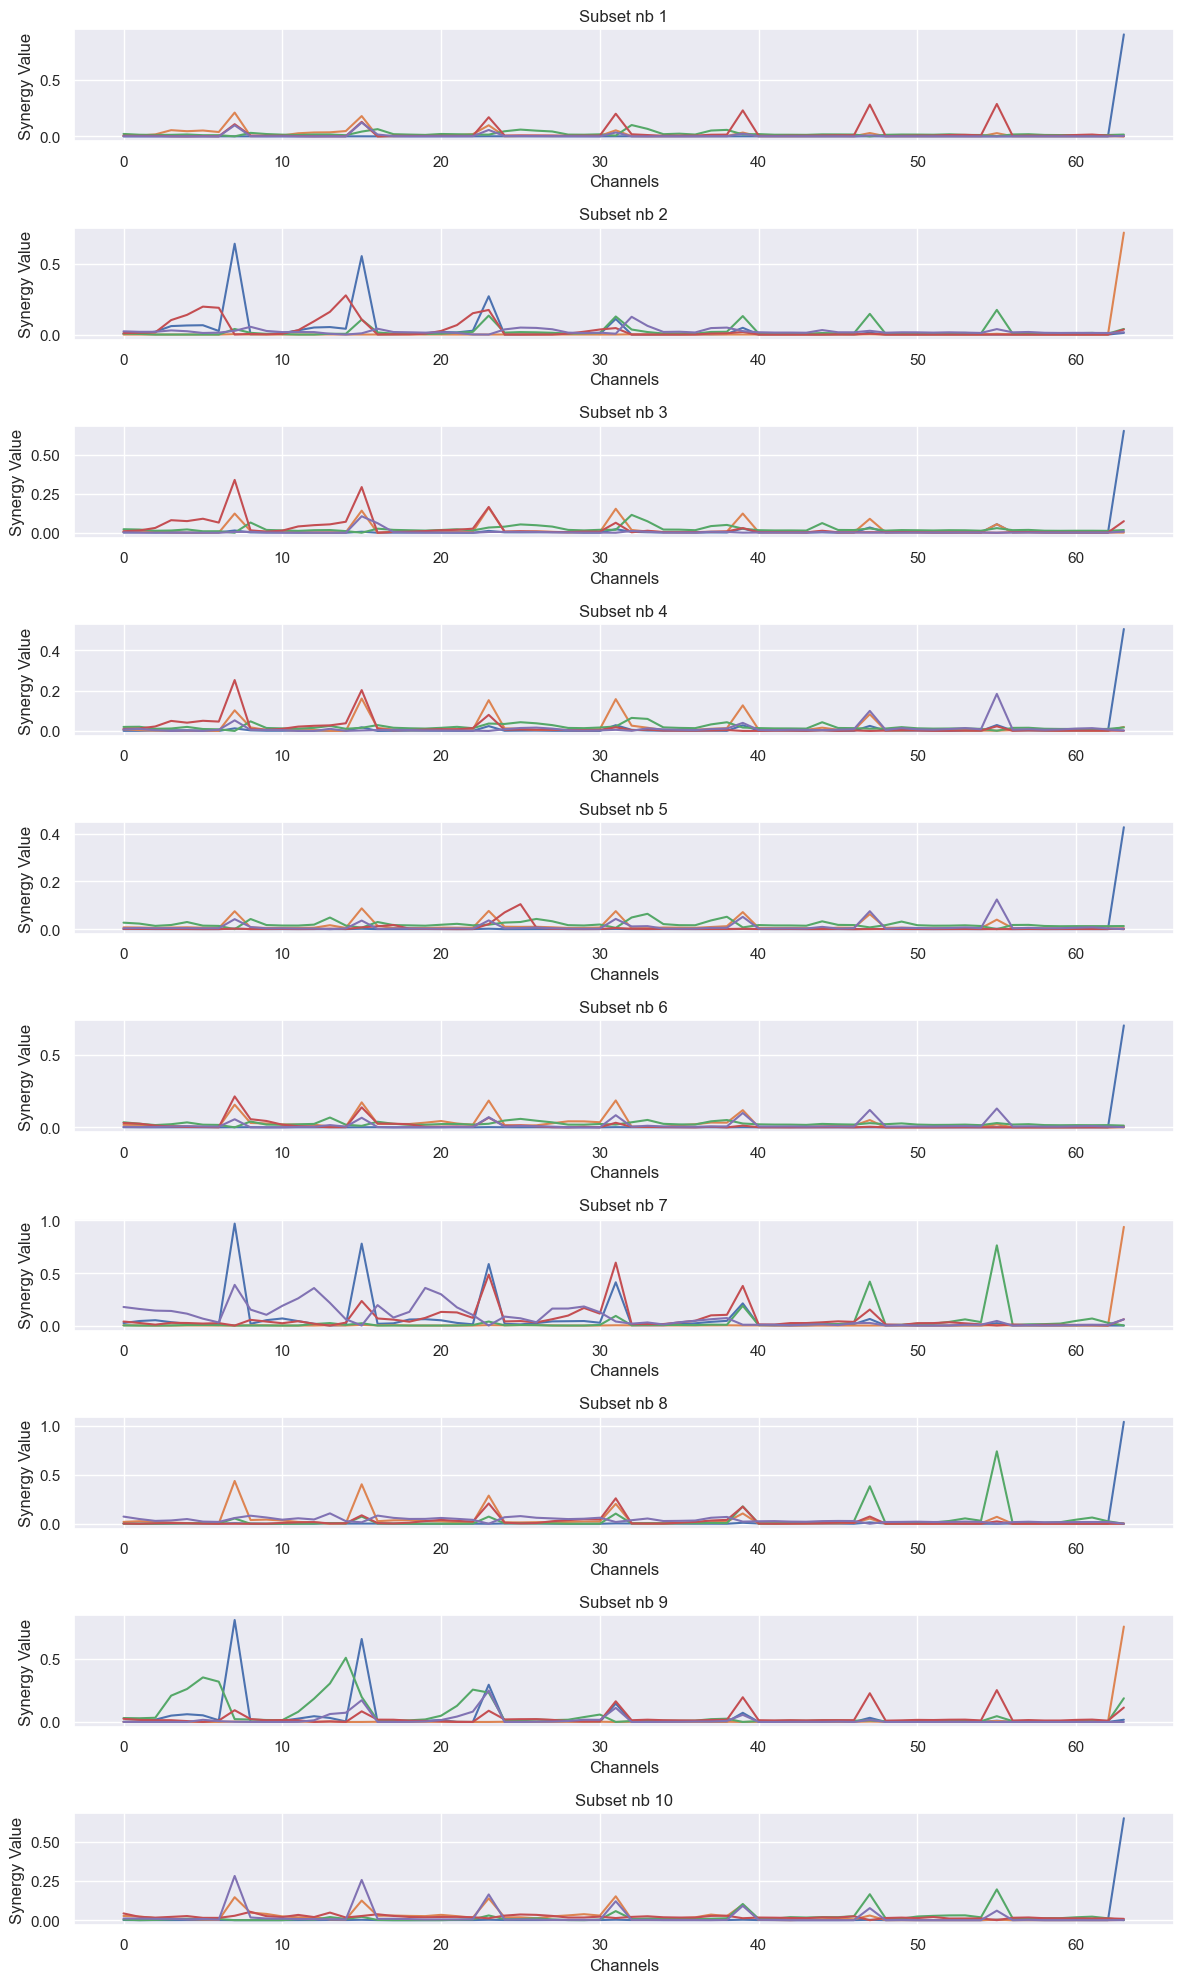

In [73]:
fig, ax = plt.subplots(n_subsets, 1, figsize=(12, 2*n_subsets))

for i in range(n_subsets):
    ax[i].plot(H_sub[i].T)
    ax[i].set_title("Subset nb {}".format(i+1))
    ax[i].set_xlabel("Channels")
    ax[i].set_ylabel("Synergy Value")
    
plt.tight_layout()
plt.show()

## Part 4
*<span style="color:green">Compute the spatial synergies for different subjects. Is it now stable across the
different subjects? </span>*


Text(0, 0.5, 'Envelope')

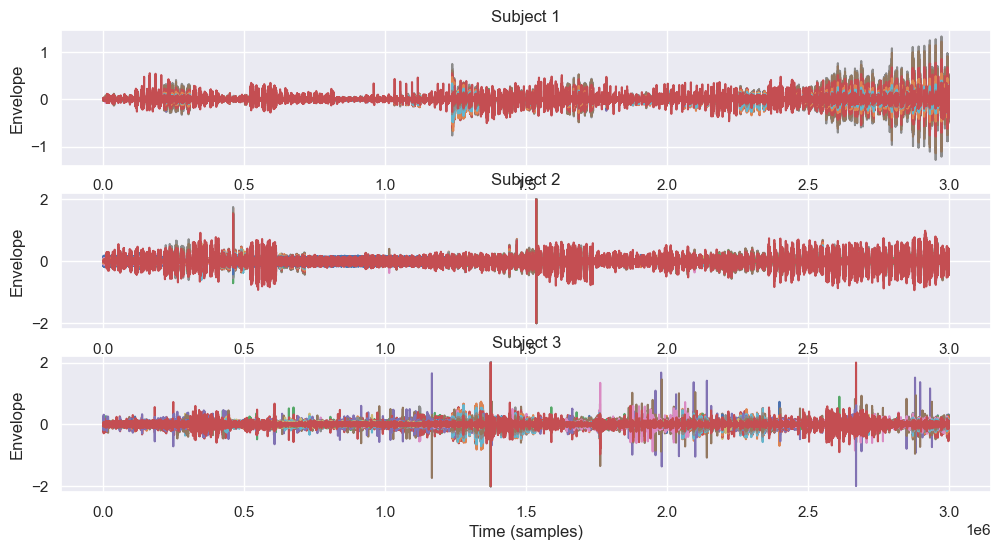

In [5]:

# Plot the three datas for each patient
fig, ax = plt.subplots(3, 1, figsize=(12, 6))

tmp_emg = sub_files[0]["emg_flexors_new"]
tmp_emg[tmp_emg > 2] = 2
tmp_emg[tmp_emg < -2] = -2
ax[0].plot(np.reshape((tmp_emg), (sub_files[0]["emg_flexors_new"].shape[0], 64)))
ax[0].set_title("Subject 1")
ax[0].set_xlabel("Time (samples)")
ax[0].set_ylabel("Envelope")

tmp_emg = sub_files[1]["emg_flexors_new"]
tmp_emg[tmp_emg > 2] = 2
tmp_emg[tmp_emg < -2] = -2
ax[1].plot(np.reshape((tmp_emg), (sub_files[1]["emg_flexors_new"].shape[0], 64)))
ax[1].set_title("Subject 2")
ax[1].set_xlabel("Time (samples)")
ax[1].set_ylabel("Envelope")

tmp_emg = sub_files[2]["emg_flexors_new"]
tmp_emg[tmp_emg > 2] = 2
tmp_emg[tmp_emg < -2] = -2
ax[2].plot(np.reshape((tmp_emg), (sub_files[2]["emg_flexors_new"].shape[0], 64)))
ax[2].set_title("Subject 3")
ax[2].set_xlabel("Time (samples)")
ax[2].set_ylabel("Envelope")

del tmp_emg

In [11]:
n_subject: int = 3
BSS = "NMF"
 
W_subject: list = []
H_subject: list = []
envelope_subject: list = []

 
for i in range(n_subject):

    emg_envelope = preprocess_data(sub=i, sub_files=sub_files)
    envelope_subject.append(emg_envelope)
    
    if BSS == "NMF":
        model = NMF(n_components=5, init="nndsvda", max_iter=500)
    elif BSS == "PCA":
        model = PCA(n_components=5) 
    elif BSS == "ICA":
        model = FastICA(n_components=5)
    model.fit(emg_envelope)
    
    W_subject.append(model.transform(emg_envelope))
    H_subject.append(model.components_)

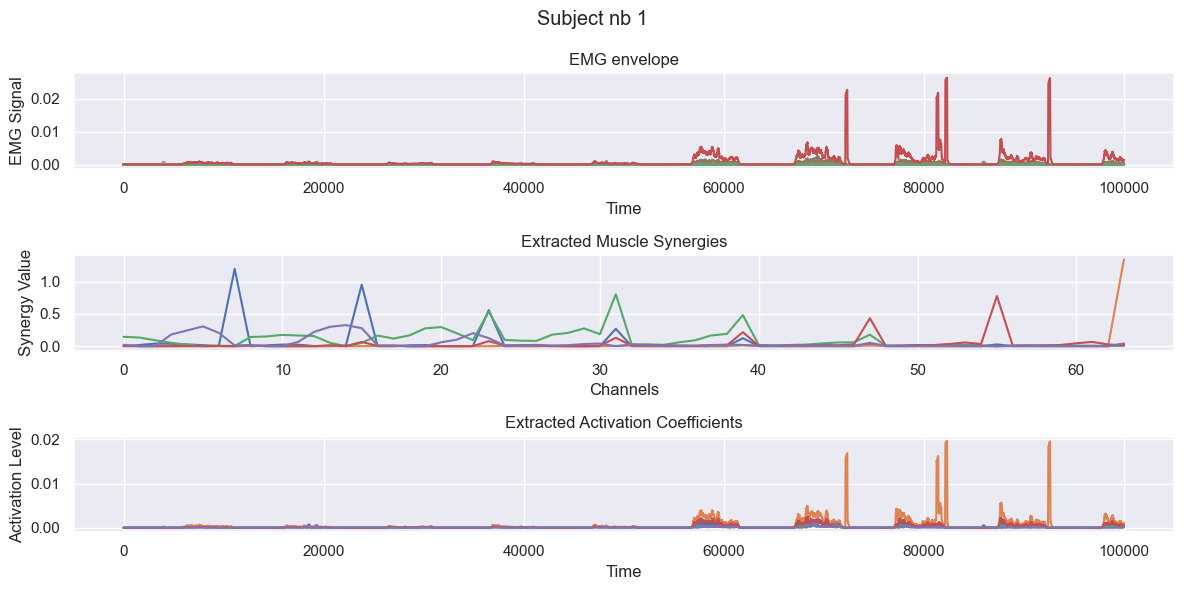

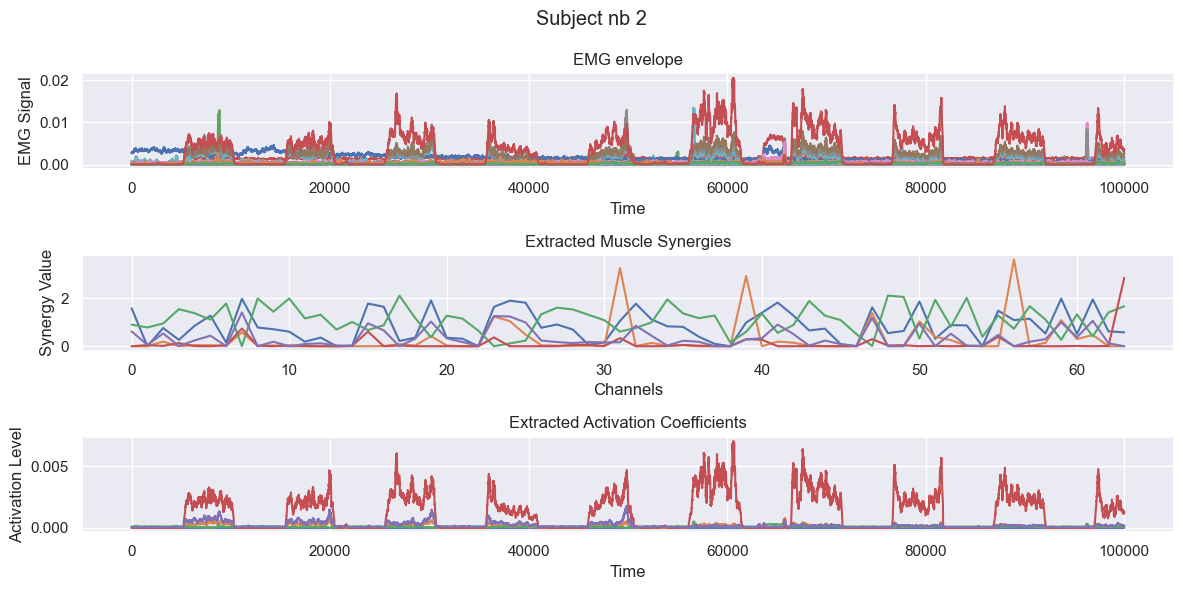

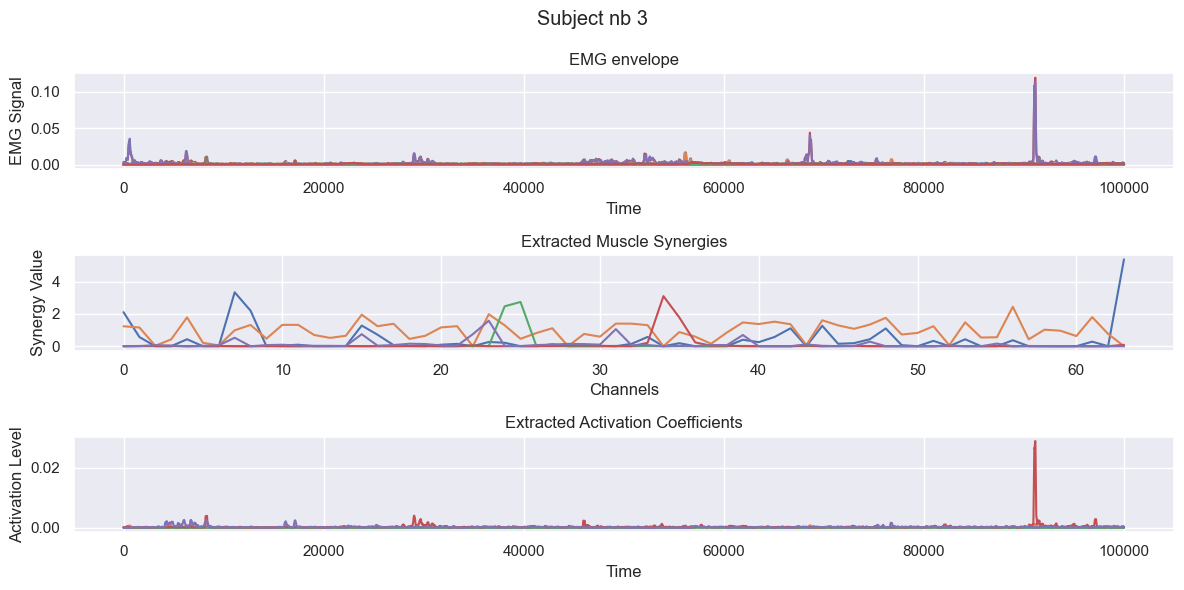

In [14]:
range_plot = 100000
start = 0

for i in range(n_subject):
    plot_synergies(envelope_subject[i][start:start+range_plot], H_subject[i], W_subject[i][start:start+range_plot], "Subject nb {}".format(i+1))

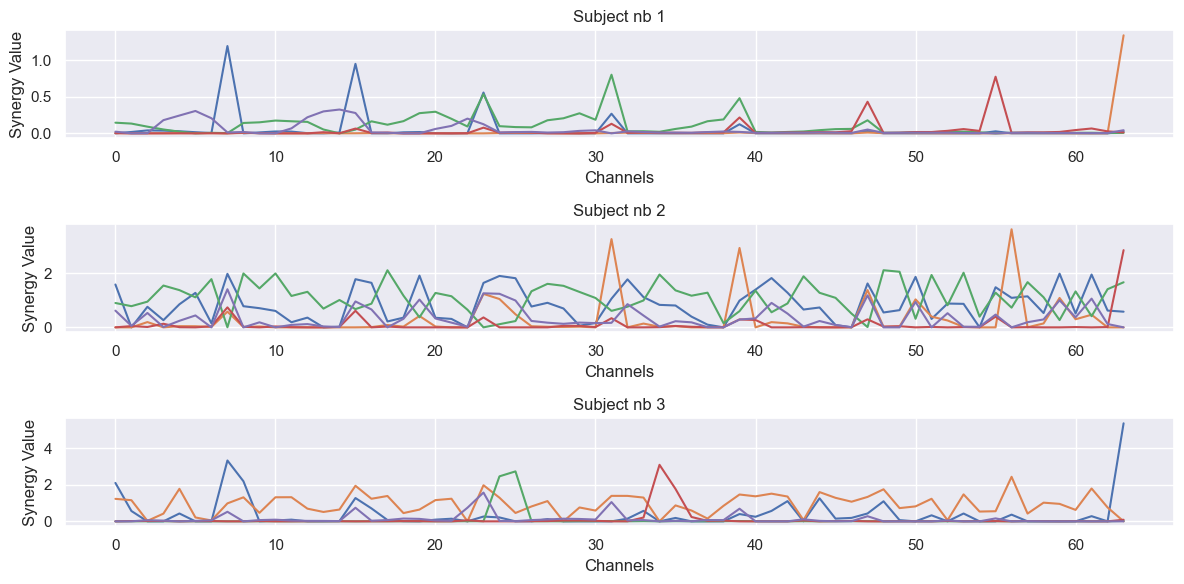

In [19]:
fig, ax = plt.subplots(n_subject, 1, figsize=(12, 2*n_subject))

for i in range(n_subject):
    ax[i].plot(H_subject[i].T)
    ax[i].set_title("Subject nb {}".format(i+1))
    ax[i].set_xlabel("Channels")
    ax[i].set_ylabel("Synergy Value")

plt.tight_layout()
plt.show()

## Part 5
*<span style="color:green">Try to vary the frequencies used in the preprocessing step. Compute the spatial
synergies again. Does the choice of filtering frequencies affects the stability of the
synergies?</span>*

In [40]:
def preprocess_data_part5(sub, sub_files, last_value=1200000, peak_value=2, Wn=(), N=4):
    Fs = sub_files[sub]['Fs'][0,0].copy()
    emg = sub_files[sub]['emg_flexors_new'].copy()
       
    emg[emg > peak_value] = peak_value
    emg[emg < -peak_value] = -peak_value
    
    n_channels = emg.shape[1]*emg.shape[2]

    emg = emg.reshape(emg.shape[0], n_channels)
    
    sos = butter(N=N, fs=Fs, Wn=Wn, btype="bandpass", output="sos")
    emg_filtered = sosfiltfilt(sos, emg.T).T
    
    # Easier method to compute the envelope 

    emg_subsampled = emg_filtered[::2, :] # subsample by steps of 2 to reduce data size for easier computation
    emg_rectified = emg_subsampled ** 2 # rectify the signal. We could also use abs

    weights = np.ones(200) / 200        
    emg_envelope_200 = convolve1d(emg_rectified, weights=weights, axis=0)
    
    emg_envelope_200 = emg_envelope_200[:last_value]
    return emg_envelope_200

In [51]:
frequencies = [(5, 167), (167, 333), (333, 500)]
sub_n = 0
BSS = "NMF"

W_freq: list = []
H_freq: list = []
envelope_freq: list = []
filtered: list = []

for frequency in frequencies:

    emg_envelope = preprocess_data_part5(sub=sub_n, sub_files=sub_files, Wn=frequency, N=4)
    
    if BSS == "NMF":
        model = NMF(n_components=5, init="nndsvda", max_iter=500)
        envelope_freq.append(emg_envelope)
        
    else:
        means_channel = np.mean(emg_envelope, axis=0)
        centered_emg = emg_envelope - np.ones(emg_envelope.shape) * means_channel

        if BSS == "PCA":
            model = PCA(n_components=5) 
        elif BSS == "ICA":
            model = FastICA(n_components=5)
            
        envelope_freq.append(centered_emg)
    
    W_freq.append(model.fit_transform(envelope_freq[-1]))
    
    if BSS == "ICA":
        H_freq.append(model.mixing_.T)
    else:
        H_freq.append(model.components_)

c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [52]:
def plot_only_synergies(H, title=None):
    
    # Plot synthetic EMG data
    plt.figure(figsize=(12, 3))

    # Plot extracted synergies
    plt.plot(H.T)
    plt.title('Extracted Muscle Synergies for ' + title)
    plt.xlabel('Channels')
    plt.ylabel('Synergy Value')

    plt.tight_layout()

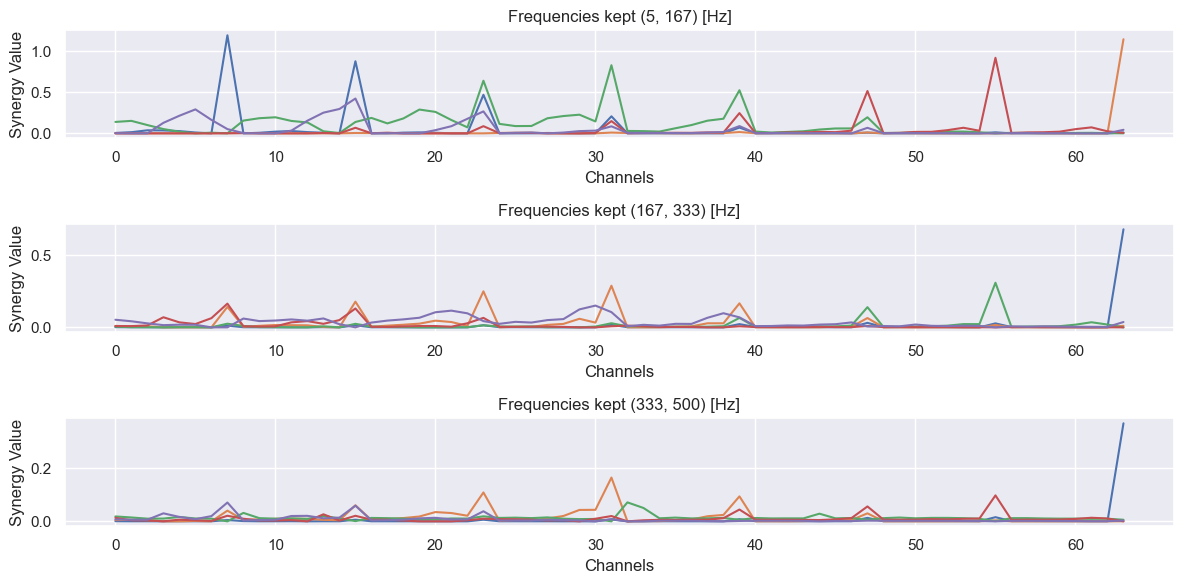

In [56]:
fig, ax = plt.subplots(len(frequencies), 1, figsize=(12, 2*len(frequencies)))

for i in range(len(frequencies)):
    ax[i].plot(H_freq[i].T)
    ax[i].set_title("Frequencies kept {} [Hz]".format(frequencies[i]))
    ax[i].set_xlabel("Channels")
    ax[i].set_ylabel("Synergy Value")
    
plt.tight_layout()
plt.show()
    

## Part 6
*<span style="color:green">Evaluate the stability of the synergies across the different BSS algorithms with
respect to the tasks 3-4-5. Which algorithm performs better, and which one is least
stable. Discuss the pros and cons of the different algorithms.</span>*


In [58]:
def mse(W, H, emg):
    reconstructed = W @ H
    mse = np.mean((emg - reconstructed) ** 2)
    return mse

In [22]:
emg_flexors_envelope_200 = preprocess_data(sub=0, sub_files=sub_files)

In [59]:
n_subsets: int = 10
interval: int = int(emg_flexors_envelope_200.shape[0]/n_subsets)
methods = ["NMF", "PCA", "ICA"]

W_sub = np.zeros((n_subsets, 3, interval, 5))
H_sub = np.zeros((n_subsets, 3, 5, 64))
mse_sub = np.zeros((n_subsets, 3))

means_channel = np.mean(emg_flexors_envelope_200, axis=0)
centered_emg = emg_flexors_envelope_200 - np.ones(emg_flexors_envelope_200.shape) * means_channel

for index, BSS in enumerate(methods):
    # Your existing code here
    if BSS == "NMF":
        model = NMF(n_components=5, init="nndsvda", max_iter=500)
        for i in range(n_subsets):
            model.fit(emg_flexors_envelope_200[i*interval:(i+1)*interval])
            W_sub[i, index] = model.transform(emg_flexors_envelope_200[i*interval:(i+1)*interval])
            H_sub[i, index] = model.components_
            
            mse_sub[i, index] = mse(W_sub[i, index], H_sub[i, index], emg_flexors_envelope_200[i*interval:(i+1)*interval])
        
    elif BSS == "PCA":
        model = PCA(n_components=5) 
        for i in range(n_subsets):
            model.fit(centered_emg[i*interval:(i+1)*interval])
            W_sub[i, index] = model.transform(centered_emg[i*interval:(i+1)*interval])
            H_sub[i, index] = model.components_
            
            mse_sub[i, index] = mse(W_sub[i, index], H_sub[i, index], centered_emg[i*interval:(i+1)*interval])
            
    elif BSS == "ICA":
        model = FastICA(n_components=5)
        for i in range(n_subsets):
            model.fit(centered_emg[i*interval:(i+1)*interval])
            W_sub[i, index] = model.transform(centered_emg[i*interval:(i+1)*interval])
            H_sub[i, index] = model.mixing_.T
            
            mse_sub[i, index] = mse(W_sub[i, index], H_sub[i, index], centered_emg[i*interval:(i+1)*interval])
        

c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.w

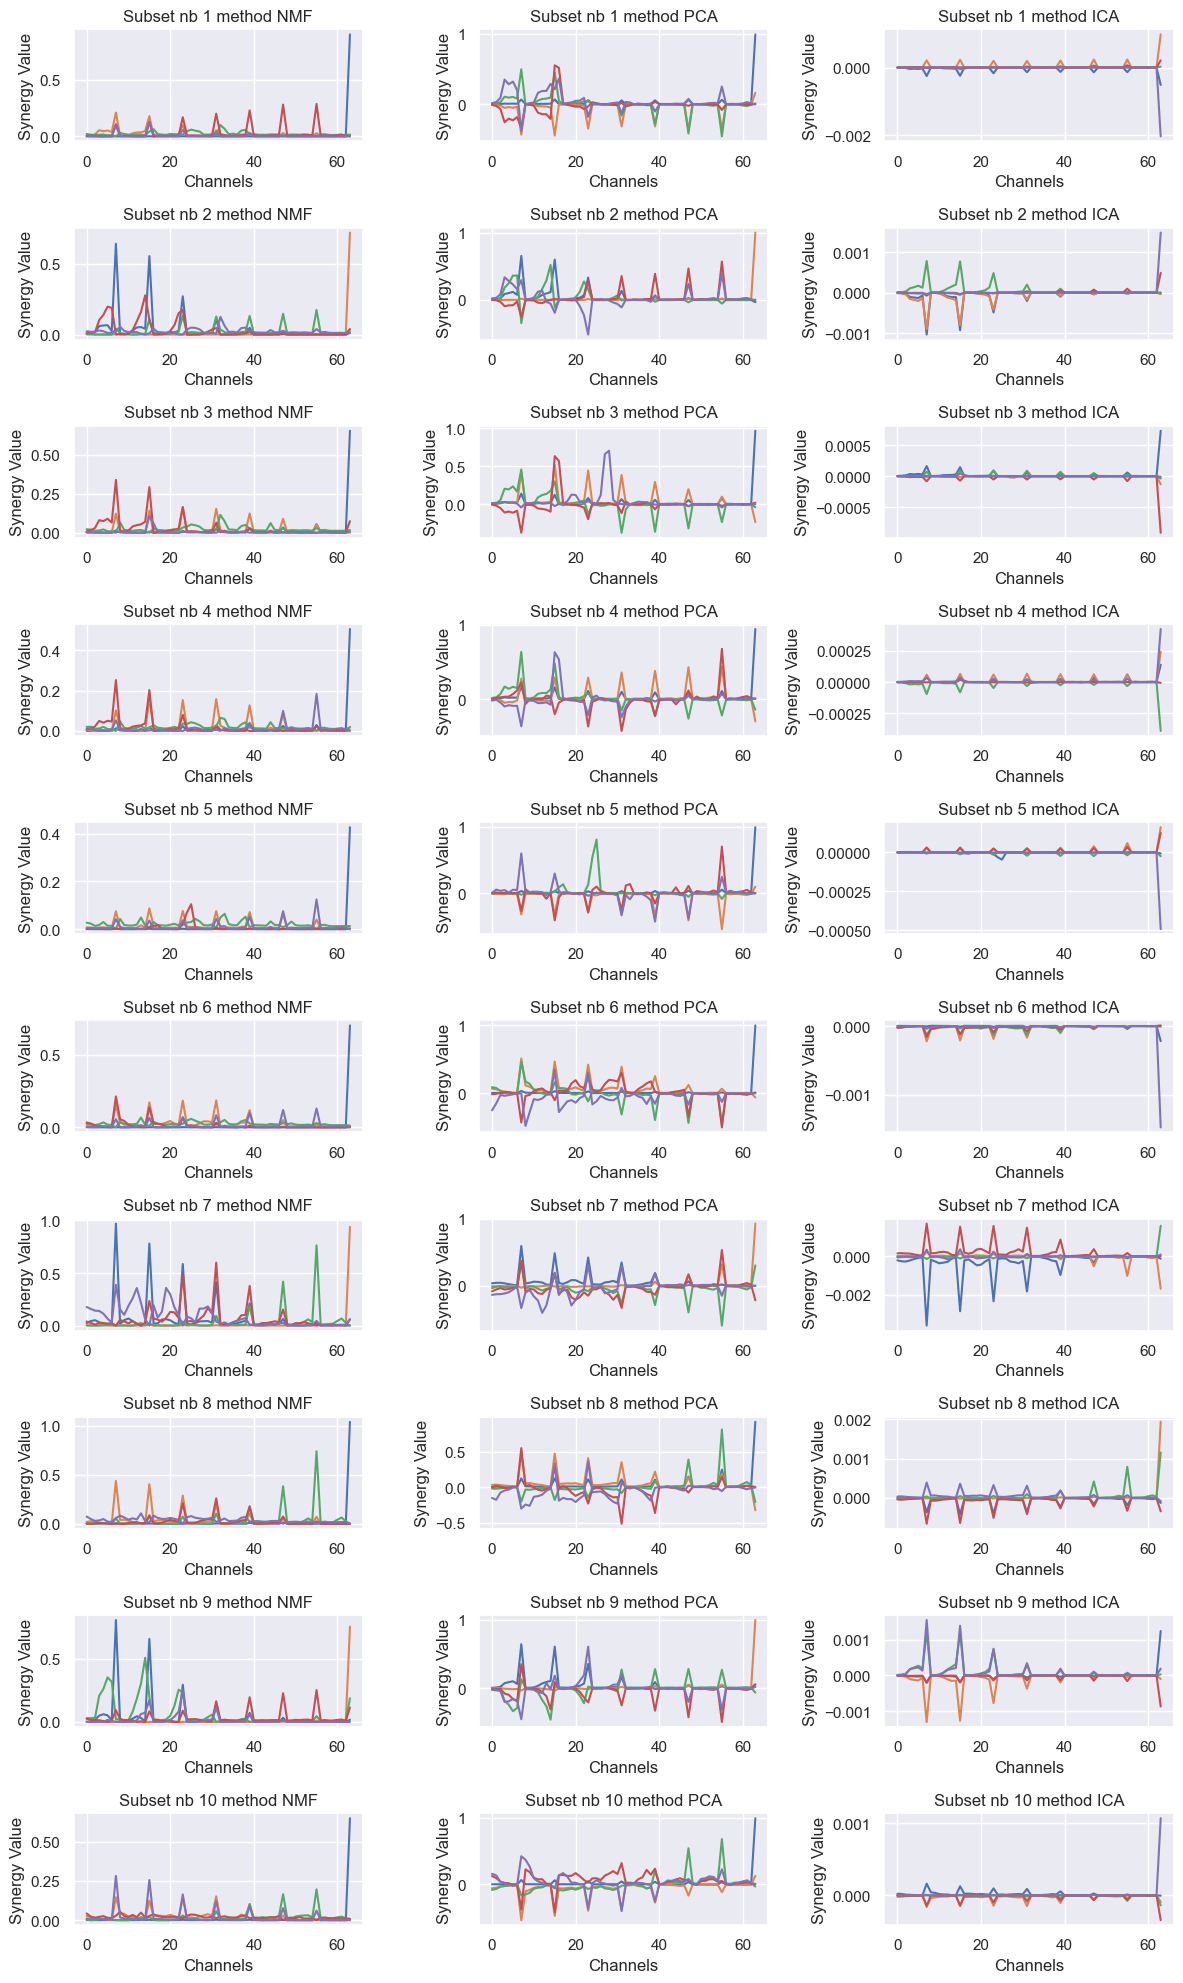

In [60]:
fig, ax = plt.subplots(n_subsets, 3, figsize=(12, 2*n_subsets))

for i in range(n_subsets):
    for j in range(3):
        ax[i, j].plot(H_sub[i, j].T)
        ax[i, j].set_title("Subset nb {} method {}".format(i+1, methods[j]))
        ax[i, j].set_xlabel("Channels")
        ax[i, j].set_ylabel("Synergy Value")
        
plt.tight_layout()
plt.show()

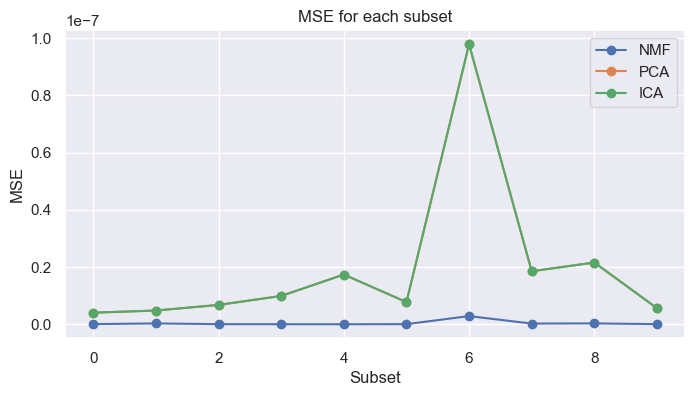

In [71]:
plt.figure(figsize=(8, 4))
plt.plot(mse_sub[:, 0], 'o-', label="NMF")
plt.plot(mse_sub[:, 1], 'o-', label="PCA")
plt.plot(mse_sub[:, 2], 'o-', label="ICA")

plt.title('MSE for each subset')
plt.xlabel('Subset')
plt.ylabel('MSE')
plt.legend()
plt.show()

Now let's compare across patients

In [34]:
envelope_subject: list = []
envelope_subject_centered: list = []
 
for i in range(len(sub_files)):    
    emg_envelope = preprocess_data(sub=i, sub_files=sub_files)
    envelope_subject.append(emg_envelope)
    
    means_channel = np.mean(emg_envelope, axis=0)
    centered_emg = emg_envelope - np.ones(emg_envelope.shape) * means_channel
    envelope_subject_centered.append(centered_emg)

In [72]:
n_subject: int = 3

methods = ["NMF", "PCA", "ICA"]

W_sub = np.zeros((n_subject, 3, envelope_subject[0].shape[0], 5))
H_sub = np.zeros((n_subject, 3, 5, 64))

mse_sub = np.zeros((n_subject, 3))

for i in range(n_subject):

    for index, BSS in enumerate(methods):
        # Your existing code here
        if BSS == "NMF":
            model = NMF(n_components=5, init="nndsvda", max_iter=500)
            model.fit(envelope_subject[i])
            W_sub[i, index] = model.transform(envelope_subject[i])
            H_sub[i, index] = model.components_
            
            mse_sub[i, index] = mse(W_sub[i, index], H_sub[i, index], envelope_subject[i])
            
        elif BSS == "PCA":
            model = PCA(n_components=5) 
            model.fit(envelope_subject_centered[i])
            W_sub[i, index] = model.transform(envelope_subject_centered[i])
            H_sub[i, index] = model.components_
            
            mse_sub[i, index] = mse(W_sub[i, index], H_sub[i, index], envelope_subject_centered[i])
                
        elif BSS == "ICA":
            model = FastICA(n_components=5)
            model.fit(envelope_subject_centered[i])
            W_sub[i, index] = model.transform(envelope_subject_centered[i])
            H_sub[i, index] = model.mixing_.T
            
            mse_sub[i, index] = mse(W_sub[i, index], H_sub[i, index], envelope_subject_centered[i])

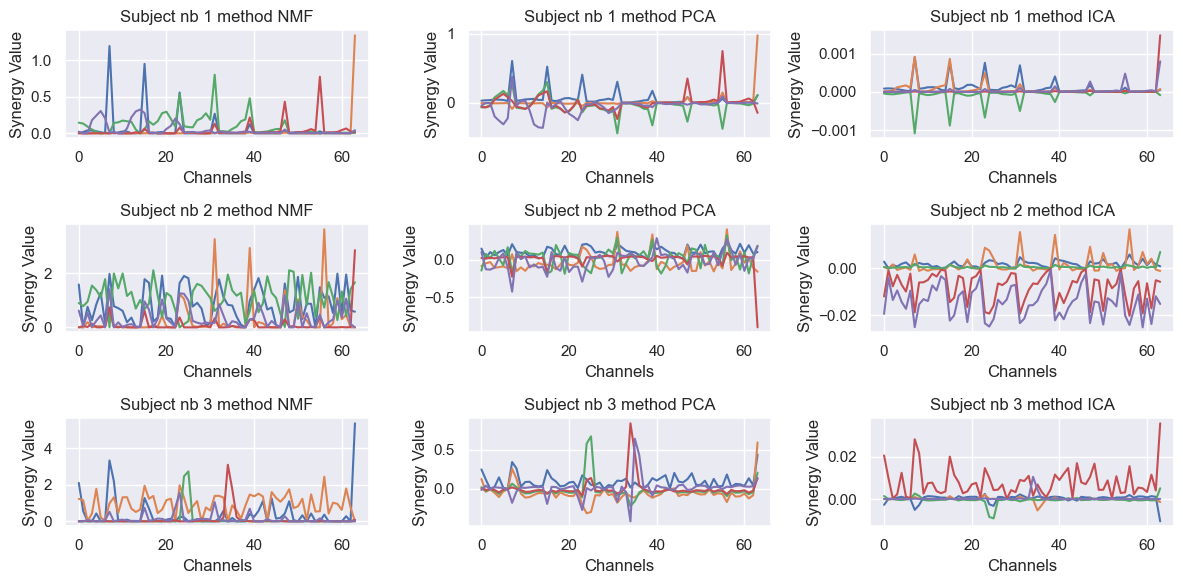

In [93]:
fig, ax = plt.subplots(n_subject, 3, figsize=(12, 2*n_subject))

for i in range(n_subject):
    for j in range(3):
        ax[i, j].plot(H_sub[i, j].T)
        ax[i, j].set_title("Subject nb {} method {}".format(i+1, methods[j]))
        ax[i, j].set_xlabel("Channels")
        ax[i, j].set_ylabel("Synergy Value")
        
plt.tight_layout()
plt.show()

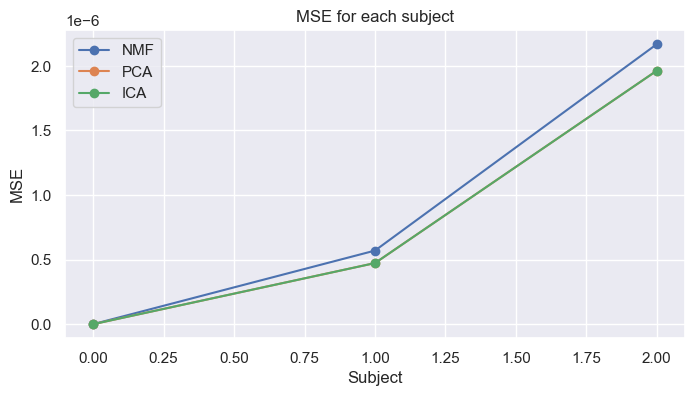

In [73]:
plt.figure(figsize=(8, 4))
plt.plot(mse_sub[:, 0], 'o-', label="NMF")
plt.plot(mse_sub[:, 1], 'o-', label="PCA")
plt.plot(mse_sub[:, 2], 'o-', label="ICA")

plt.title('MSE for each subject')
plt.xlabel('Subject')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
frequencies = [(5, 167), (167, 333), (333, 500)]
sub_n = 0
BSS = "NMF"

W_freq: list = []
H_freq: list = []
envelope_freq: list = []
filtered: list = []

for frequency in frequencies:

    emg_envelope = preprocess_data_part5(sub=sub_n, sub_files=sub_files, Wn=frequency, N=4)
    
    if BSS == "NMF":
        model = NMF(n_components=5, init="nndsvda", max_iter=500)
        envelope_freq.append(emg_envelope)
        
    else:
        means_channel = np.mean(emg_envelope, axis=0)
        centered_emg = emg_envelope - np.ones(emg_envelope.shape) * means_channel

        if BSS == "PCA":
            model = PCA(n_components=5) 
        elif BSS == "ICA":
            model = FastICA(n_components=5)
            
        envelope_freq.append(centered_emg)
    
    W_freq.append(model.fit_transform(envelope_freq[-1]))
    
    if BSS == "ICA":
        H_freq.append(model.mixing_.T)
    else:
        H_freq.append(model.components_)

In [ ]:
fig, ax = plt.subplots(len(frequencies), 1, figsize=(12, 2*len(frequencies)))

for i in range(len(frequencies)):
    ax[i].plot(H_freq[i].T)
    ax[i].set_title("Frequencies kept {} [Hz]".format(frequencies[i]))
    ax[i].set_xlabel("Channels")
    ax[i].set_ylabel("Synergy Value")
    
plt.tight_layout()
plt.show()